In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vespainv.model import VespaModel, Prior
from vespainv.waveformBuilder import create_U_from_model

In [5]:
# --- Time and STF setup ---
dt = 0.01
time = np.arange(-10, 30, dt)
stf_time = np.arange(-1, 1, dt)
stf = np.exp(-((stf_time / 0.2)**2))  # Gaussian STF

In [6]:
# --- Synthetic model setup ---
# model = VespaModel.create_empty(Nphase=1, Ntrace=5)
# model.arr[0] = 10.0      # arrival at 10s
# model.slw[0] = 0.05      # s/deg
# model.amp[0] = 1.0       # unit amplitude
# model.distDiff[0] = 0.0
# model.bazDiff[0] = 0.0

In [7]:
# --- Station metadata with small perturbations ---
np.random.seed(0)
base_dist = 35.0
base_baz = 70.0
Ntrace = 10
dists = base_dist + np.random.uniform(-0.0, 0.0, Ntrace)
bazs = base_baz + np.random.uniform(-10.0, 10.0, Ntrace)
station_metadata = np.column_stack((dists, bazs))

# --- Prior ---
prior = Prior(refLat = 0., refLon = 0.,refBaz=base_baz, timeRange=(time[0],time[-1]))

In [15]:
model = VespaModel.create_random(Nphase=3, Ntrace=Ntrace, time=time, prior=prior)
print(model)

VespaModel(Nphase=3, Ntrace=10, arr=array([27.74048566, 17.26599376,  4.37672094]), slw=array([-0.02518722,  0.07905248, -0.17590981]), amp=array([ 0.33353343,  0.34127574, -0.57923488]), distDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), bazDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


In [16]:
# --- Generate synthetic seismograms ---
U = create_U_from_model(model, prior, station_metadata, time, stf_time, stf)


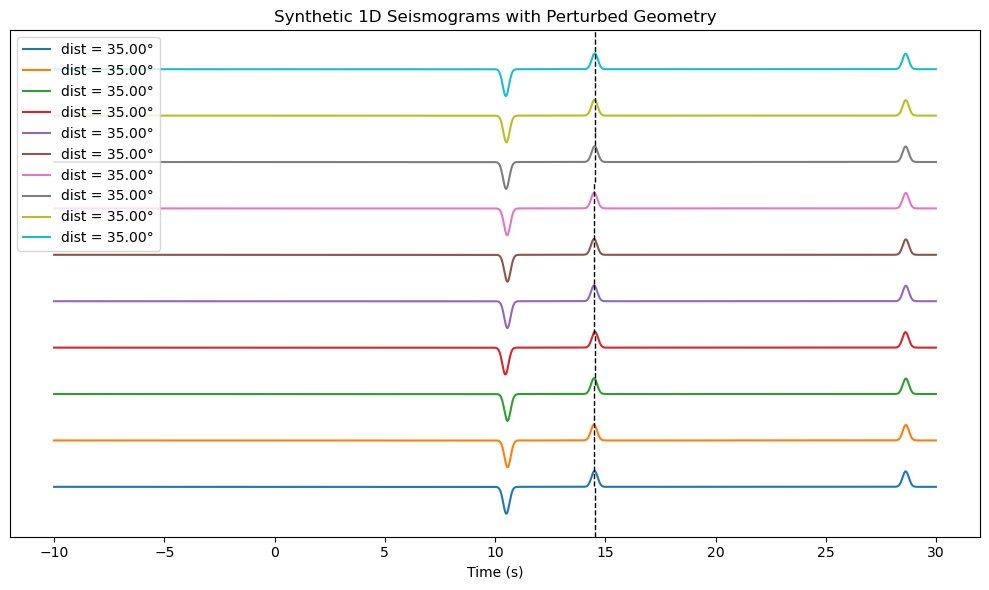

In [17]:
# --- Plot ---
plt.figure(figsize=(10, 6))
for i in range(U.shape[0]):
    trace = U[i]
    plt.plot(time, trace + i, label=f'dist = {dists[i]:.2f}°')

    # Find peak time
    peak_idx = np.argmax(trace)
    peak_time = time[peak_idx]
    plt.axvline(x=peak_time, ymin=i / U.shape[0], ymax=(i + 1) / U.shape[0],
                color='k', linestyle='--', linewidth=1)

plt.xlabel("Time (s)")
plt.title("Synthetic 1D Seismograms with Perturbed Geometry")
plt.yticks([])
plt.legend()
plt.tight_layout()
# plt.xlim(5, 15)
plt.show()


In [11]:
from vespainv.utils import dest_point

lat1 = 4.5
lon1 = 135.9
baz = 77
dist = 28.7

lat2, lon2 = dest_point(lat1, lon1, baz, dist)
print(lat2, lon2)

10.16676782304183 164.28407774089493


VespaModel3c(Nphase=3, Ntrace=50, arr=array([30, 60, 90], dtype=int32), slw=array([0.02454388, 0.08035901, 0.01963813]), amp=array([0.8287552 , 0.70370466, 0.91950144]), dip=array([36.93019552, 79.27927648, 77.15441276]), azi=array([121.49896421,  13.30787306,  18.47498263]), ph_hh=array([ 19.644717  ,   9.16823693, -86.64641769]), ph_vh=array([-14.04101018, -69.63250878,  80.29103658]), atts=array([3.16267135, 0.98050581, 2.80151043]), svfac=array([0.75064144, 0.59597878, 0.63114388]), wvtype=array([1, 1, 0], dtype=int32), distDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), bazDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


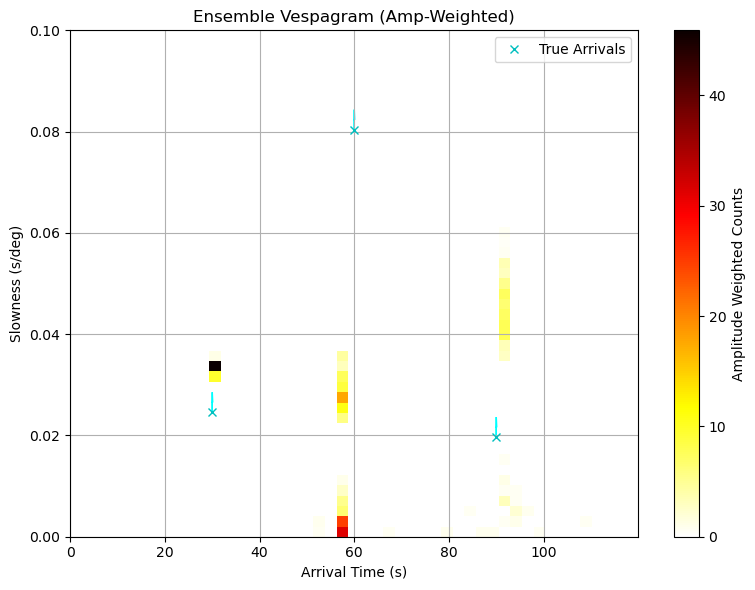

In [1]:
from vespainv.visualization import plot_ensemble_vespagram
import pickle, os
import numpy as np

synDir = "./synData/model3/"
resDir = "./runs/syn/model3/run2.1_T=0.1_freq/"

with open(os.path.join(resDir, "ensemble.pkl"), "rb") as f:
    ensemble = pickle.load(f)
with open(os.path.join(synDir, "synPrior.pkl"), "rb") as f:
    prior = pickle.load(f)
with open(os.path.join(synDir, "synModel.pkl"), "rb") as f:
    model = pickle.load(f)
Utime  = np.loadtxt(os.path.join(synDir, "time_syn.csv"), delimiter=",")  # columns: time

plot_ensemble_vespagram(ensemble, Utime, prior, amp_weighted=True, true_model=model)
print(model)

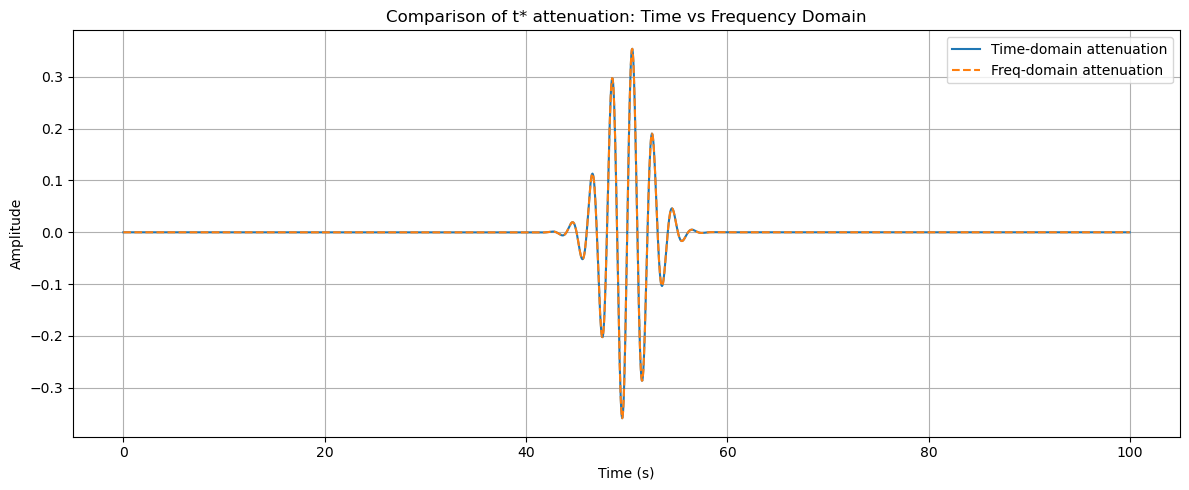

In [30]:
import numpy as np
from vespainv.waveformBuilder import tstar_conv

def tstar_conv_freqdomain(W: np.ndarray, freqs: np.ndarray, t_star: float) -> np.ndarray:
    """
    Apply t* attenuation in the frequency domain.

    Parameters:
    - W: Fourier-transformed waveform (1D complex array)
    - freqs: frequency array corresponding to W
    - t_star: t* value

    Returns:
    - W_attenuated: Attenuated waveform in frequency domain
    """
    f = freqs * t_star
    f0 = 1.0 * t_star  # reference frequency
    f_f0 = f / f0

    # Create attenuation operator
    attenuation = np.exp(-np.pi * f) * np.power(
        f_f0, 1j * 2 * f, where=f_f0 > 0, out=np.zeros_like(f_f0, dtype=complex)
    )
    W_attenuated = W * attenuation
    W_attenuated[0] = 0  # Zero the DC component

    return W_attenuated

# === Cross check ===
import matplotlib.pyplot as plt

# Create test waveform
dt = 0.05
N = 2000
time = np.arange(N) * dt
f0 = 0.5  # dominant frequency
wvfm = np.sin(2 * np.pi * f0 * time) * np.exp(-((time - 50)**2) / 10)

# FFT of original waveform
W = np.fft.fft(wvfm)
freqs = np.fft.fftfreq(N, dt)

# Apply both methods
t_star = 0.2
wvfm_att_time = tstar_conv(wvfm, time, t_star)
W_att = tstar_conv_freqdomain(W, freqs, t_star)
wvfm_att_freq = np.fft.ifft(W_att).real

# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(time, wvfm_att_time, label="Time-domain attenuation")
plt.plot(time, wvfm_att_freq, label="Freq-domain attenuation", linestyle='--')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Comparison of t* attenuation: Time vs Frequency Domain")
plt.grid(True)
plt.tight_layout()
plt.show()


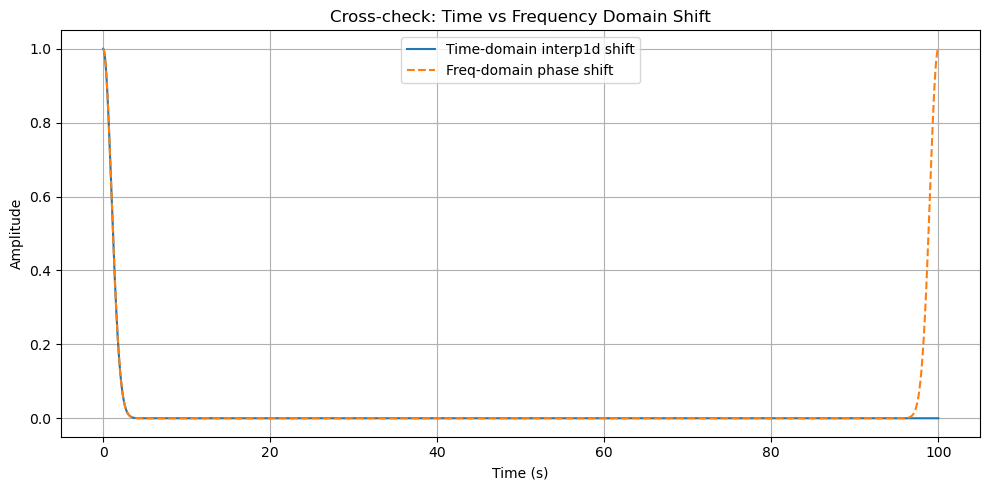

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftfreq

# Parameters
dt = 0.01
N = 1000          # Length of original waveform
Nlong = 10000     # Length of target waveform (longer to hold shift)
time = np.arange(N) * dt  # Original time vector
timelong = np.arange(Nlong) * dt  # Target time vector
freq_long = fftfreq(Nlong, dt)

tshift = -5  # seconds

# Generate test waveform (Gaussian pulse)
center = 5.0
width = 1.0
P_wvlt = np.exp(-((time - center) ** 2) / (2 * width ** 2))

# ----------------------------
# TIME-DOMAIN INTERPOLATION SHIFT
# ----------------------------
# Interpolate with shifted time vector and evaluate at timelong
P_shifted_time = interp1d(
    time + tshift,
    P_wvlt,
    kind='linear',
    bounds_error=False,
    fill_value=0.0
)(timelong)

# ----------------------------
# FREQUENCY-DOMAIN PHASE SHIFT
# ----------------------------
# Zero-pad P_wvlt to match Nlong
P_wvlt_padded = np.pad(P_wvlt, (0, Nlong - N))

# FFT of the zero-padded waveform
P_wvlt_W = fft(P_wvlt_padded)

# Apply phase shift in frequency domain
phase_shift = np.exp(-2j * np.pi * freq_long * tshift)
P_wvlt_W_shifted = P_wvlt_W * phase_shift

# IFFT to get back the time-domain waveform
P_shifted_freq = np.real(ifft(P_wvlt_W_shifted))

# ----------------------------
# PLOT FOR CROSS-CHECK
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(timelong, P_shifted_time, label='Time-domain interp1d shift')
plt.plot(timelong, P_shifted_freq, '--', label='Freq-domain phase shift')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Cross-check: Time vs Frequency Domain Shift")
plt.grid(True)
plt.tight_layout()
plt.show()


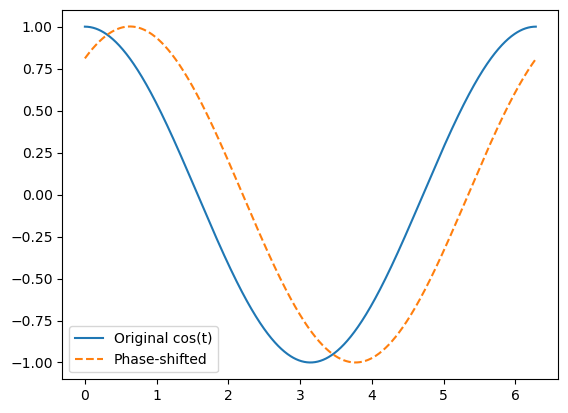

In [29]:
import numpy as np

def apply_constant_phase_shift(W: np.ndarray, freqs: np.ndarray, phase_rad: float) -> np.ndarray:
    """
    Apply a constant phase shift in the frequency domain.

    Parameters:
    - W: complex FFT of the signal (1D array)
    - freqs: frequency array corresponding to W (from fftfreq)
    - phase_rad: phase shift in radians (e.g., np.pi/2 for 90°)

    Returns:
    - W_shifted: FFT of the signal with phase shift applied
    """
    N = len(W)
    phase_shift = np.ones(N, dtype=complex)

    # Sort out which indices are positive/negative freqs
    if N % 2 == 0:
        # Even length
        phase_shift[1:N//2] = np.exp(-1j * phase_rad)
        phase_shift[N//2+1:] = np.exp(1j * phase_rad)
        phase_shift[N//2] = 1  # Nyquist
    else:
        # Odd length
        phase_shift[1:(N+1)//2] = np.exp(-1j * phase_rad)
        phase_shift[(N+1)//2:] = np.exp(1j * phase_rad)

    return W * phase_shift

from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

t = np.linspace(0, 2 * np.pi, 1000)
f = np.cos(t)
W = fft(f)
freqs = fftfreq(len(f), d=(t[1] - t[0]))

W_shifted = apply_constant_phase_shift(W, freqs, np.pi/5)
f_shifted = np.real(ifft(W_shifted))

plt.plot(t, f, label='Original cos(t)')
plt.plot(t, f_shifted, '--', label='Phase-shifted')
plt.legend()
plt.show()


/var/folders/97/hmqn6c1x37z45n0h_x530rg80000gn/T/ipykernel_10027/2758900630.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z_fft[i], R_fft[i], T_fft[i] = Z_i, R_i, T_i


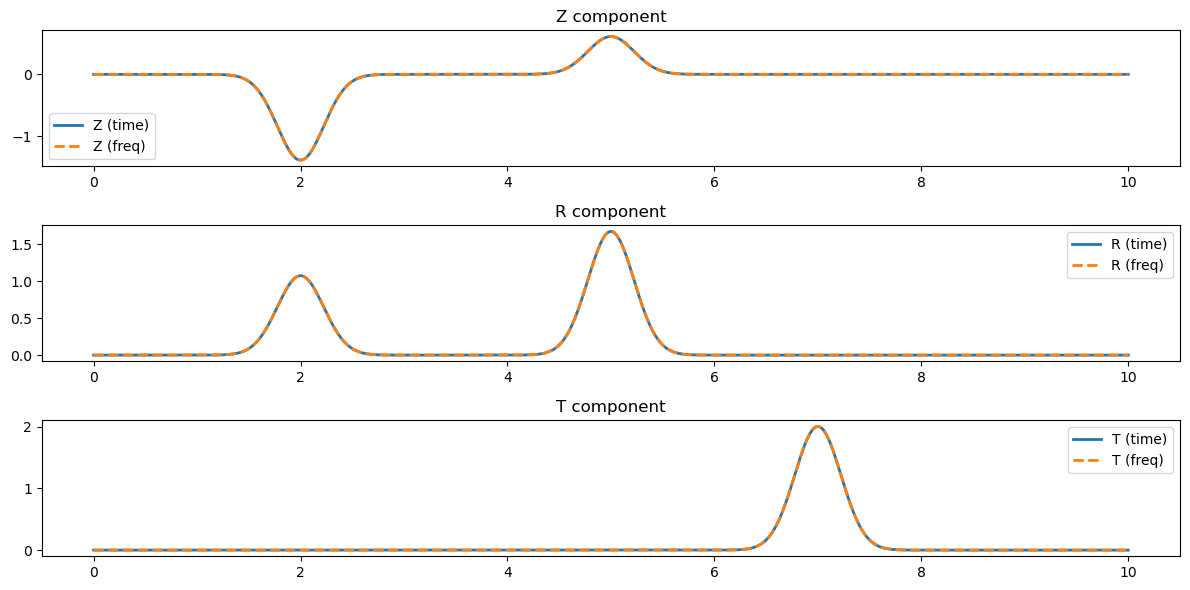

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from vespainv.waveformBuilder import PVH_to_ZRT

# Generate synthetic PVH time series
n = 1024
t = np.linspace(0, 10, n)
P = np.exp(-((t - 2)**2) / 0.1)         # P pulse at t=2
SV = np.exp(-((t - 5)**2) / 0.1)        # SV pulse at t=5
SH = np.exp(-((t - 7)**2) / 0.1)        # SH pulse at t=7

# Slowness value
slw = 0.1

# --- Time domain rotation ---
Z_time, R_time, T_time = PVH_to_ZRT(P, SV, SH, slw)

# --- Frequency domain rotation ---
# FFT
P_fft = fft(P)
SV_fft = fft(SV)
SH_fft = fft(SH)

# Apply rotation in frequency domain
Z_fft = np.zeros_like(P_fft, dtype=complex)
R_fft = np.zeros_like(P_fft, dtype=complex)
T_fft = np.zeros_like(P_fft, dtype=complex)

for i in range(n):
    P_i, SV_i, SH_i = P_fft[i], SV_fft[i], SH_fft[i]
    Z_i, R_i, T_i = PVH_to_ZRT(P_i, SV_i, SH_i, slw)
    Z_fft[i], R_fft[i], T_fft[i] = Z_i, R_i, T_i

# Inverse FFT to get time series
Z_freq = np.real(ifft(Z_fft))
R_freq = np.real(ifft(R_fft))
T_freq = np.real(ifft(T_fft))

# --- Compare results ---
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(t, Z_time, label='Z (time)', lw=2)
plt.plot(t, Z_freq, '--', label='Z (freq)', lw=2)
plt.legend(); plt.title('Z component')

plt.subplot(3, 1, 2)
plt.plot(t, R_time, label='R (time)', lw=2)
plt.plot(t, R_freq, '--', label='R (freq)', lw=2)
plt.legend(); plt.title('R component')

plt.subplot(3, 1, 3)
plt.plot(t, T_time, label='T (time)', lw=2)
plt.plot(t, T_freq, '--', label='T (freq)', lw=2)
plt.legend(); plt.title('T component')

plt.tight_layout()
plt.show()
